In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def cvtToPos(feat_map): # feat_map = [cx, cy, w, h]
    left_upper_x = feat_map[0] - int(feat_map[2]/2)
    left_upper_y = feat_map[1] - int(feat_map[3]/2)
    right_lower_x = feat_map[0] + int(feat_map[2]/2)
    right_lower_y = feat_map[1] + int(feat_map[3]/2)
    return np.array([left_upper_x, left_upper_y, right_lower_x, right_lower_y])

def cvtEdge2Center(rect): # rect = [left_upper_x, left_upper_y, w, h]
    cx = rect[0] + int(rect[2]/2)
    cy = rect[1] + int(rect[3]/2)
    return np.array([cx, cy, rect[2], rect[3]])

In [3]:
# compute feature map positions
def generate_feature_maps(imgage_size=(300, 300), #(width, height)
                           div_width=5,
                           div_height=5):
    feat_maps = []
    
    im_w = imgage_size[1]
    im_h = imgage_size[0]

    feat_w = int(im_w / div_width)
    feat_h = int(im_h / div_height)

    feat_c_x = np.array([int(feat_w / 2) + 1 + n * feat_w for n in range(div_width)])
    feat_c_y = np.array([int(feat_h / 2)+ 1 + n * feat_h for n in range(div_height)])

    for j in range(div_height):
        for i in range(div_width):
            feat_maps.append(np.array([feat_c_x[i],
                                       feat_c_y[j],
                                       feat_w,
                                       feat_h]))
            
    return feat_maps #(cx, cy, w, h) 

In [4]:
def generate_default_boxes(feat_maps, aspects=[1, 2, 1/2], s=1):
    def_boxes = []
    for feat in feat_maps: 
        feat_w = feat[2]
        feat_h = feat[3]
        for ar in aspects:
            w = int(feat_w * s * ar **0.5)
            h = int(feat_h * s * (1/ar) ** 0.5)
            def_boxes.append(np.array([feat[0],
                                     feat[1], 
                                    w, 
                                    h]))
    return def_boxes

In [5]:
def normalize(target, ref): # ref might be default box
    cx = (target[0] - ref[0]) / ref[2]
    cy = (target[1] - ref[1]) / ref[3]
    w = np.log(target[2]/ref[2])
    h = np.log(target[3]/ref[3])
    return np.array([cx, cy, w,h])

def smoothL1(target, ref):
    diff = np.linalg.norm((target - ref), ord=2)
    if diff > 1:
        return diff -  0.5
    else:
        return 0.5 * diff ** 2

In [6]:
image_path = 'test.jpg'
image = Image.open(image_path)
print(image.format, image.size, image.mode)

JPEG (710, 398) RGB


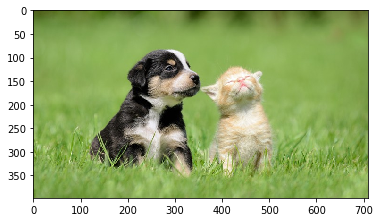

In [7]:
im_original = cv2.imread(image_path)
im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
plt.imshow(im_original)

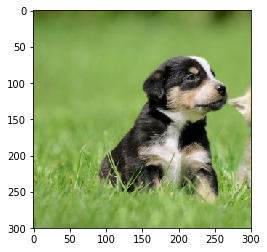

In [8]:
x = 0
y = 0
w = min(im_original .shape[0:2])
h = min(im_original .shape[0:2])
im = im_original[y:y+h, x:x+w]
im = cv2.resize(im,(300,300))
plt.imshow(im)

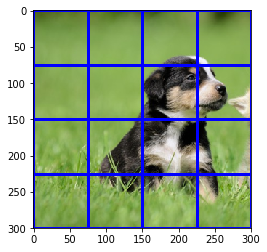

In [9]:
feat_maps = generate_feature_maps(im.shape[0:2],
                           div_width=4,
                           div_height=4)
color = (0, 0, 255)
for b in feat_maps:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

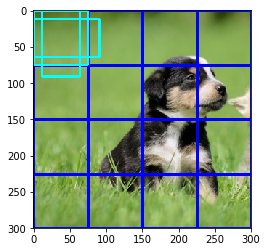

In [10]:
def_boxes = generate_default_boxes(feat_maps, [1, 2, 1/2], 1)
color = (0, 255, 255)
for b in def_boxes[0:3]:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

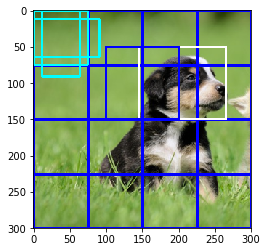

In [11]:
pred_box = np.array([[150, 100, 100, 100]])
box_gt = np.array([[205, 100, 120, 100]])

color = (255, 255, 255)
rect = cvtToPos(box_gt[0])
cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
color = (0, 0, 255)
for b in pred_box:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

In [12]:
norm_gt_box = []
norm_pred_box = []
for d in def_boxes:
    norm_gt_box.append(normalize(box_gt[0], d))
    norm_pred_box.append(normalize(pred_box[0], d)) 

In [13]:
loss = 0
for j in range(len(def_boxes)):
    loss += 1 * smoothL1(norm_gt_box[j], norm_pred_box[j])

In [14]:
loss

15.845957061887265

In [15]:
cvtToPos(box_gt[0])

array([145,  50, 265, 150])

In [16]:
cvtToPos(pred_box[0])

array([100,  50, 200, 150])

In [17]:
def box_area(box): #box = [cx, cy, w, h]
    return box[2] * box[3]

def cross_area(tar_box, ref_box):
    pixels = 0
    ref_area = cvtToPos(ref_box)
    tar_area = cvtToPos(tar_box)
    for i in range(tar_box[2]):
        for j in range(tar_box[3]):
            w_bool = tar_area[0] + i >= ref_area[0] and tar_area[0] + i <= ref_area[2]
            h_bool = tar_area[1] + j >= ref_area[1] and tar_area[1] + j <= ref_area[3]
            if w_bool and h_bool:
                pixels += 1
    return pixels

def IoU(tar_box, ref_box):
    return cross_area(tar_box, ref_box)/(box_area(tar_box) + box_area(ref_box))

In [18]:
cross_area([50,50,100,100], [149,149,100,100])

1

In [19]:
box_gt[0]

array([205, 100, 120, 100])

In [20]:
pred_box[0]

array([150, 100, 100, 100])

In [21]:
5600 / (100*100 + 120*100)

0.2545454545454545

In [22]:
for b in def_boxes:
    print(IoU(box_gt[0], b))

0.0
0.0
0.0
0.008851063829787235
0.01873084345555682
0.0
0.11063829787234042
0.08258599159950052
0.12634805312748326
0.057531914893617024
0.04682710863889204
0.06674991485980247
0.0
0.0
0.0
0.025191489361702128
0.06618231354296741
0.0
0.3148936170212766
0.2918038369849018
0.2707458281303213
0.16374468085106383
0.16545578385741855
0.14303553184243387
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04512430468838688
0.0
0.0
0.023839255307072312
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
